# Traffic Sign Classifier

This project aims at correctly classifying the German traffic signs by using $convolutional\ neural\ networks$ for deep learning.
So let us start and import all the packages required.

## Imports and function library

In [1]:
import pickle
import random
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Image libraries for image processing
import matplotlib.image as mpimg
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

'''
    Function to convert a RGB image to grayscale image
'''
def rgb2gray(img):
    gray = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
    return gray

'''
    Function to get probabilities for all classes, where index in array is class and value at index is probability.
    
    @Arguments
        tensor_op: Output of classification session, having list of probabilities at index as class number.
        total_images_in_set: total number of images classified in 'tensor_op'
        top_n: how many classifications with more probability to choose from the set.
    @Return
        'top_n' classes having highest probabilities as a list containing tuples having class and probability pairs.
'''
def zipProbabilityWithClass(tensor_op, total_images_in_set, top_n):
    tpf_p_l = [None]*total_images_in_set
    for i in range(total_images_in_set):
        tpf_p = []
        tpf_d = {}
        pb = tensor_op[i][0]
        for p in range(len(pb)):
            tpf_p.append(pb[p])
            tpf_d[pb[p]] = p 
        tpf_p.sort(reverse=True)
        #print(tpf_p)
        tpf_p_l[i] = []
        itm_l = []
        for j in range(top_n):
            tpf_p_l[i].append(tpf_d[tpf_p[j]])
            itm_l.append(tpf_p[j])
        tpf_p_l[i] = list(zip(tpf_p_l[i], itm_l))
    return tpf_p_l

'''
    Read the labels from the input file name 'class_file'.
'''
def getClassesFromFile(class_file):
    file = open(class_file, 'r')
    txt = file.read().split('\n')[1:]
    file.close()
    signs = []
    for line in txt:
        signs.append(line.split(',')[-1])
    return signs

'''
    Function to prepare images for training.
    Preparation is done as follows:
        > Convert to grayscale(32x32)
        > Change shape to 32x32x1
    Output structure of set is same as input.
'''
def prepareImageSet(image_set, label_set):
    #convert to grayscale
    image_set = [rgb2gray(img).reshape((32,32,1)) for img in image_set]
    return image_set, label_set

'''
    Read the images from 'image_dir' having names in list 'image_names' and prepare a set which
    would be used for prediction.
    Returns two sets, one normal and one grayscale.
'''
def prepareSetWithNewImages(image_dir, image_names):
    test_images = []
    test_images_g = []
    for i in range(len(image_names)):
        img = Image.open(image_dir+image_names[i])
        resized_img = img.resize((32, 32))
        resized_arr = np.asarray(resized_img)
        test_images.append(resized_arr)
        resized_arr = rgb2gray(resized_arr).reshape((32,32,1))
        test_images_g.append(resized_arr)
    return test_images, test_images_g

### Load the data

Data is downloaded into the root directory of the project repository and unzipped before loading.

In [2]:
# Load pickled data
training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

# Load signs from file "signames.csv"
signs = getClassesFromFile("signames.csv")

### Dataset Summary & Exploration

Code to print the basic summary of training, validation and testing datasets. Some random images from the training set along with their index numbers are shown.

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
--------------------------
Some random images from the training set.


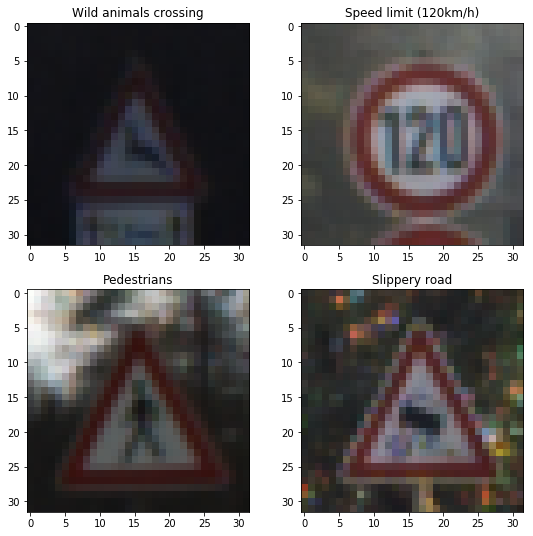

--------------------------

Some images for "33:Turn right ahead"


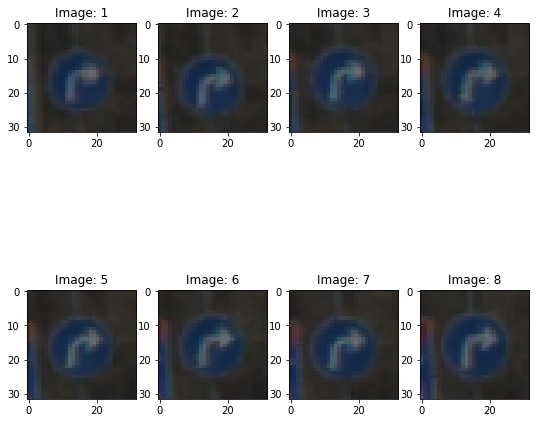

--------------------------
Distribution on images among classes


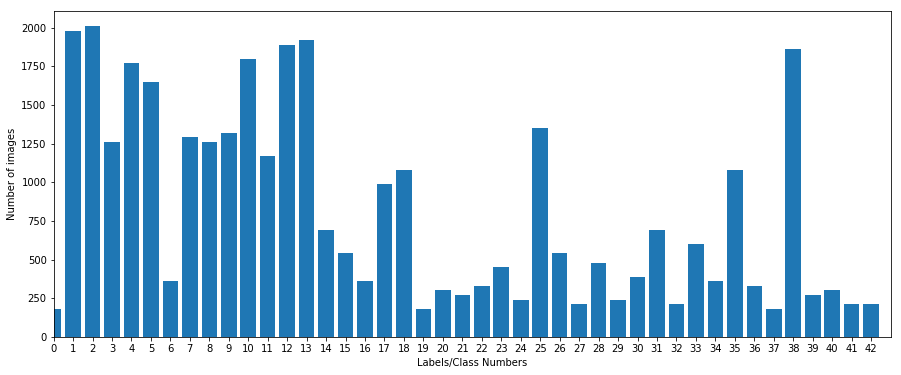

In [3]:
%matplotlib inline
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.copy(y_train)
n_classes = len(set(n_classes))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

# Display some images from the training set.
print("--------------------------")
print("Some random images from the training set.")

fig = plt.figure(figsize=(9,9))
for i in range(4):
    sf = fig.add_subplot(2, 2, i+1)
    ri = random.randint(0, len(X_train))
    plt.imshow(X_train[ri])
    sf.set_title(signs[y_train[ri]])
plt.show()

print("--------------------------")
print()
sign_no = 33 #random.randint(0, len(signs))
print('Some images for "'+str(sign_no)+':'+signs[sign_no]+'"')
img = []
i=0
while True:
    if y_train[i] == sign_no:
        img.append(X_train[i])
    if len(img) == 8:
        break
    i+=1

fig1 = plt.figure(figsize=(9,9))
for i in range(8):
    sf = fig1.add_subplot(2, 4, i+1)
    plt.imshow(img[i])
    sf.set_title("Image: "+str(i+1))
plt.show()
print("--------------------------")
print("Distribution on images among classes")
dist = [0]*n_classes
ty = list(y_train)
for i in range(n_classes):
    dist[i] = ty.count(i)

fig2 = plt.figure(figsize=(15,6))
plt.xlabel("Labels/Class Numbers")
plt.ylabel("Number of images")
plt.axis([0, n_classes, 0, max(dist)+100])
plt.bar(list(range(n_classes)), dist)
plt.xticks(list(range(n_classes)), list(range(n_classes)))
plt.show()

From the images displayed above we can observe that the edges of the images do not contain much useful data and can be ignored while processing.

## Model Architecture Design

This deep learning model is designed by using LeNet as base and adjusting the hyperparameters according to the current dataset. This model can give accuracy of above 0.95 on validation and test set. So, let us start by preprocessing the data.

### Pre-process Data Set

Dataset consists of 32x32 RGB images which might have been taken in different lighting conditions. For this dataset, which contains German traffic signs, the shape is much more important than color of the image. So, following are the pre-processing done on the dataset:
1. Convert to grayscale(32x32) and reshape to 32x32x1
2. Shuffle the entire set

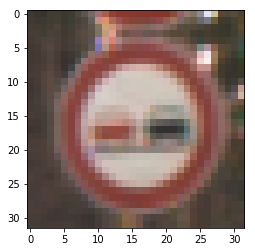

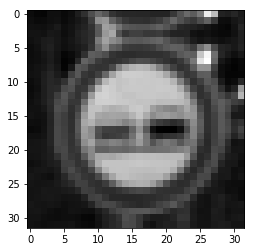

In [4]:
plt.imshow(X_train[11212])
plt.show()
plt.imshow(rgb2gray(X_train[11212]), cmap="gray")
plt.show()
# function usage: image_set, label_set = prepareImageSet(image_set, label_set)
# it converts to grayscale the input dataset
X_train, y_train = prepareImageSet(X_train, y_train)
#X_train, y_train = shuffle(X_train, y_train)

X_valid, y_valid = prepareImageSet(X_valid, y_valid)
X_test, y_test = prepareImageSet(X_test, y_test)


### Model Architecture

This model contains 2 2D convolutions with max pooling layers followed by fully connected layers with dropouts. Relu is used as activation function throughout the model. Valid padding is used in first convolutional layer since images in dataset do not have any useful information near the edges.

In [5]:

def modelNet(x):
    mu = 0.001
    sigma = 0.1
    keep_prob = 0.9
    weights = {
        "cnv1": tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean = mu, stddev = sigma)),
        "cnv2": tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean = mu, stddev = sigma)),
        "cnv3": tf.Variable(tf.truncated_normal(shape=(7*7*64, 1024), mean = mu, stddev = sigma)),
        "cnv4": tf.Variable(tf.truncated_normal(shape=(1024, 172), mean = mu, stddev = sigma)),
        "cnv5": tf.Variable(tf.truncated_normal(shape=(172, n_classes), mean = mu, stddev = sigma))
    }
    biases = {
        'bcv1': tf.Variable(tf.zeros([32])),
        'bcv2': tf.Variable(tf.zeros([64])),
        'bcv3': tf.Variable(tf.zeros([1024])),
        'bcv4': tf.Variable(tf.zeros([172])),
        'bcv5': tf.Variable(tf.zeros([n_classes]))
    }
    # Layer 1: Convolutional. Input=32x32x1, Output = 28x28x32
    layer = tf.nn.conv2d(x, weights['cnv1'], strides=[1,1,1,1], padding="VALID") + biases['bcv1']
    layer = tf.nn.relu(layer)
    #Pooling, Input = 28x28x32, Output = 14x14x32
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    # Layer 2: Convolutional. Input=14x14x32, Output = 14x14x64
    layer = tf.nn.conv2d(layer, weights['cnv2'], strides=[1,1,1,1], padding="SAME") + biases['bcv2']
    layer = tf.nn.relu(layer)
    #Pooling, Input = 14x14x64, Output = 7x7x64
    layer = tf.nn.max_pool(layer, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    
    #flatten the image, output = 3136
    layer = flatten(layer)
    layer = tf.nn.dropout(layer, keep_prob) #keep_prob = 0.9
    
    #Layer 3: Fully connected Input = 3136, Output = 1024
    layer = tf.add(tf.matmul(layer, weights['cnv3']), biases['bcv3'])
    layer = tf.nn.relu(layer)
    
    #Layer 4: Fully connected Input = 1024, Output = 172
    layer = tf.add(tf.matmul(layer, weights['cnv4']), biases['bcv4'])
    layer = tf.nn.relu(layer)
    layer = tf.nn.dropout(layer, 0.85)
    
    #Layer 5: Fully connected Input = 172, Output = 43
    layer = tf.add(tf.matmul(layer, weights['cnv5']), biases['bcv5'])
    logits = tf.nn.softmax(layer)
    return logits

Following function is used for evaluation of the model.

In [6]:
# Evaluate the model against the input set.
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Train and Validate the Model

Learning rate is set to a lower value such that the model reaches 0.9 accuracy in 40-60 epochs. Maximum epochs are 200. When maximum accuracy is captured, learning is stopped. Following code defines different operations which could be run by using tensorflow session.

In [7]:
x = tf.placeholder(tf.float32, (None, 32,32,1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

rate = 0.000361
MAX_EPOCHS = 200
BATCH_SIZE = 128
#dropout = 0.80

logits = modelNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Softmax probabilities
sfm_pbs = tf.nn.softmax(logits)

# Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

Following is the code for training and validating the dataset. A plot showing the reducing error with increasing epochs is displayed to visualize the learning.

<IPython.core.display.Javascript object>


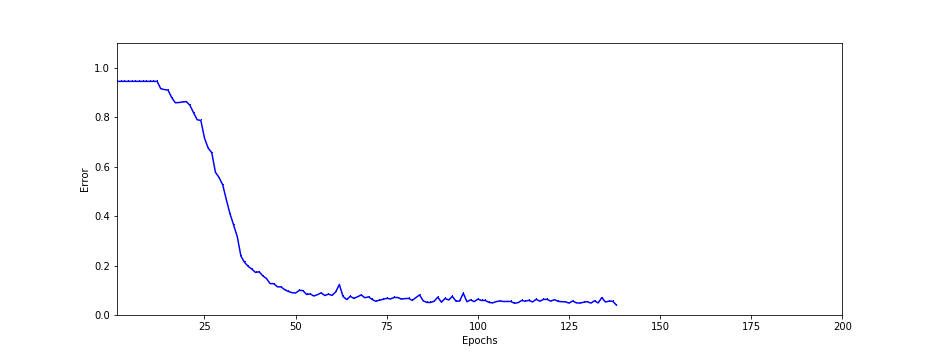

Training...
|>-------------------------------------------------------------------------------------------------------------------------------------------|
Model saved
Validation Accuracy: 0.9599
Training Accuracy: 0.9987


<IPython.core.display.Javascript object>


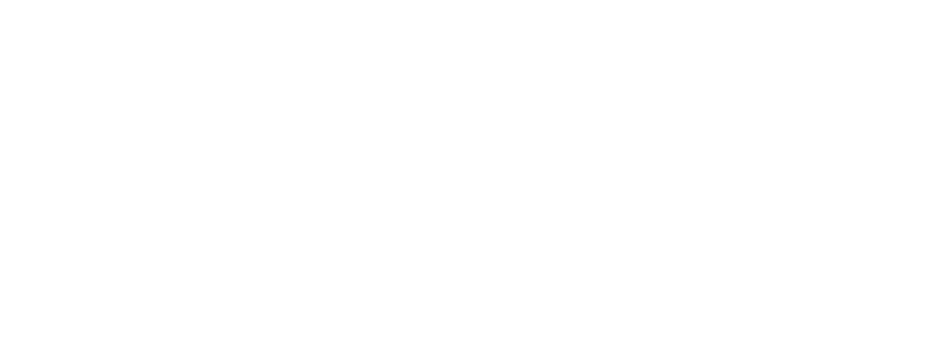

In [8]:
#Initializations for the plot
# display live chart in notebook
%matplotlib notebook
ac_list = [None]*(MAX_EPOCHS+1)    # list of accuracies achieved in each epoch while training

plt.ion()       # enable interactive plotting
fig = plt.figure(figsize=(13,6))
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.axis([1, MAX_EPOCHS, 0, 1.1])
line1, = plt.plot(list(range(MAX_EPOCHS+1)), ac_list, 'b-') 
line1.set_marker(',')
plt.show()

ac_list[0] = 1
line1.set_ydata(ac_list)
fig.canvas.draw()

#start learning
c_epoch = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print('|>', end='')
    #Train until target is reached
    while True:
        if c_epoch >= MAX_EPOCHS:
            break
        c_epoch += 1
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid).round(4)
        #print("Epoch {} ...".format(c_epoch), "Validation Accuracy = {:.3f}".format(validation_accuracy))
        print('-', end='')
        # Update the plot
        ac_list[c_epoch-1] = 1-validation_accuracy
        line1.set_ydata(ac_list)
        fig.canvas.draw()
        if validation_accuracy > 0.955:
            print('|')
            training_accuracy = evaluate(X_train, y_train).round(4)
            break
        
    saver.save(sess, './model')
    print("Model saved")
print("Validation Accuracy:", validation_accuracy)
print("Training Accuracy:", training_accuracy)

### Testing on Test Dataset

In [9]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.941


## Test Model on New Images

For testing the performance of this model, five images are acquired from internet and resized to 32x32 size before use so that they can be used with this model.

### Load and Output the Images

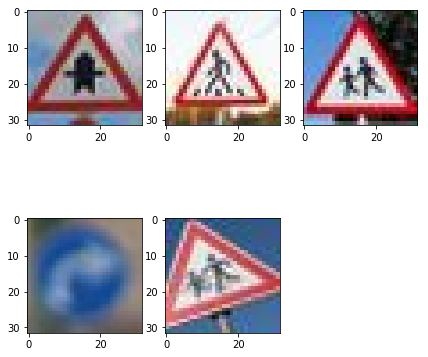

In [10]:
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline

test_img_dir = "./test_images/"
test_img_names = ["img1.jpg", "img2.jpg", "img3.jpg", "img4.jpg", "img5.jpg"]

# test_images are color images and test_images_g are grayscale equivalents
test_images, test_images_g = prepareSetWithNewImages(test_img_dir, test_img_names)
y_new = [11, 27, 28, 33, 28]

fig = plt.figure(figsize=(7,7))
for i in range(5):
    sf = fig.add_subplot(2, 3, i+1)
    plt.imshow(test_images[i])

### Sign Type Prediction

In [20]:
#restore variable state from saved model and get the softmax probabilities for each image
res_l = [None]*5
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #get softmax probabilities
    for i in range(5):
        #res_l[i] = sess.run(sfm_pbs, feed_dict={x:test_images_g[i:i+1]})logits
        res_l[i] = sess.run(logits, feed_dict={x:test_images_g[i:i+1]})



### Performance on New Images

-----------------------


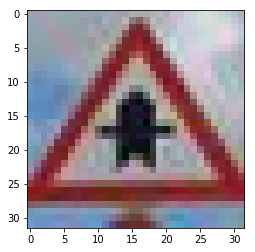

Right-of-way at the next intersection : 70.4536
Road narrows on the right : 9.26092
Beware of ice/snow : 1.58514
Slippery road : 0.407898
End of no passing by vehicles over 3.5 metric tons : 0.0
-----------------------


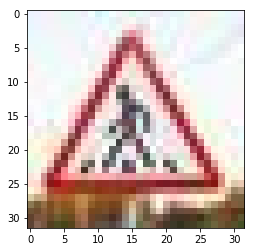

Right-of-way at the next intersection : 65.3969
General caution : 25.196
Road narrows on the right : 7.99817
Pedestrians : 6.14035
Speed limit (100km/h) : 4.72464
-----------------------


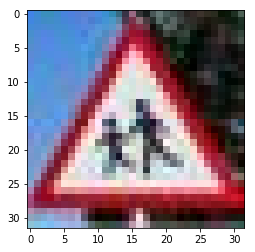

Bicycles crossing : 21.5949
Road work : 20.0578
Turn left ahead : 16.1744
Bumpy road : 15.7583
Ahead only : 13.0292
-----------------------


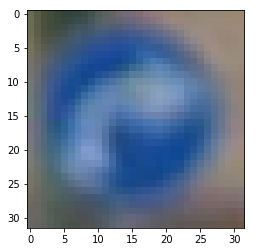

Yield : 38.9696
Turn right ahead : 27.0573
Stop : 9.18128
Ahead only : 3.85787
No passing for vehicles over 3.5 metric tons : 0.141524
-----------------------


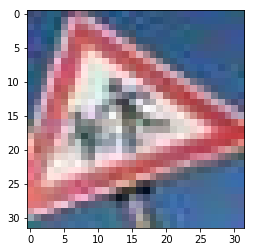

Road work : 89.9159
Dangerous curve to the right : 75.826
Yield : 48.6117
Go straight or right : 31.0793
Double curve : 23.5935
-----------------------


In [21]:
# get top 5 predictions for each of the images
tpf_p_l = zipProbabilityWithClass(res_l, 5, 5)

#Display votes
fig = plt.figure()
plt.show()
print('-----------------------')
for i in range(5):
    sf = fig.add_subplot(5, 1, i+1)
    plt.imshow(test_images[i])
    plt.show()
    for v in tpf_p_l[i]:
        print(signs[v[0]],":",v[1])
    print('-----------------------')

## Visualize the Neural Network's State with Test Images

In [13]:
### Visualize network's feature maps here.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(sess, image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    print(activation.shape)
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('model.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(sess, test_images_g, logits)

(5, 43)


IndexError: tuple index out of range